### Importing Libraries

In [2]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

### Defining functions

#### Loading dataset

In [3]:
# Step 1: Load and Normalize Dataset
def load_mnist_data():
    """Load MNIST dataset with normalization."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize dataset
    ])
    train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)
    return train_dataset, test_dataset

#### Extracting samples

In [10]:
def extract_and_save_samples(dataset, specified_classes=[3, 5, 6], samples_per_class=1000):
    """
    Extract a specified number of samples from specific classes and save them.

    Args:
        dataset: The dataset to extract samples from.
        specified_classes (list): List of class labels to extract samples for.
        samples_per_class (int): Number of samples to extract per class.

    Returns:
        extracted_data: Subset of the dataset containing extracted samples.
        remaining_data: Subset of the dataset containing remaining samples.
        classes: List of classes for which samples were extracted.
    """
    # Ensure only the specified classes are used
    print(f"Extracting samples for classes: {specified_classes}")

    extracted_indices = []
    for cls in specified_classes:
        # Find indices of the specified class
        cls_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]
        if len(cls_indices) < samples_per_class:
            print(f"Warning: Only {len(cls_indices)} samples available for class {cls}, fewer than {samples_per_class}.")
        extracted_indices.extend(cls_indices[:samples_per_class])

    # Determine remaining data indices
    remaining_indices = list(set(range(len(dataset))) - set(extracted_indices))

    # Create a directory to save the extracted samples
    os.makedirs('extracted_samples', exist_ok=True)
    for cls in specified_classes:
        cls_indices = [i for i in extracted_indices if dataset[i][1] == cls]
        cls_samples = [dataset[i] for i in cls_indices]
        torch.save(cls_samples, f'extracted_samples/class_{cls}.pt')
        print(f"Saved {len(cls_samples)} samples for class {cls}.")

    # Create subsets for extracted and remaining data
    extracted_data = Subset(dataset, extracted_indices)
    remaining_data = Subset(dataset, remaining_indices)

    return extracted_data, remaining_data, specified_classes

#### Defining model

In [4]:
# Step 2: Define Model Using Class
class SimpleNN(nn.Module):
    """Define a simple neural network as a class."""
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

#### Training and validating

In [12]:
# Step 3: Train Model with tqdm
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    """Train the model and plot accuracy/loss."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss, test_loss = [], []
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        # Training phase with tqdm
        model.train()
        running_loss, correct = 0.0, 0
        # Wrap the train_loader with tqdm for progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", ncols=100):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / len(train_loader.dataset))

        # Validation phase with tqdm
        model.eval()
        running_loss, correct = 0.0, 0
        # Wrap the test_loader with tqdm for progress bar
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", ncols=100):
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        test_loss.append(running_loss / len(test_loader))
        test_acc.append(correct / len(test_loader.dataset))

        # Print the epoch results
        print(f"Epoch {epoch + 1}/{epochs} -> Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

    # Plot results
    plot_metrics(train_loss, test_loss, train_acc, test_acc)

    return model

#### Ploting loss and accuracy curves

In [13]:
def plot_metrics(train_loss, test_loss, train_acc, test_acc):
    """Plot training and validation loss/accuracy."""
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, test_acc, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

#### Evaluating Model

In [14]:
# Step 4: Model Evaluation
def evaluate_model(model, data_loader, class_names):
    """Evaluate model performance."""
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

loading dataset

In [8]:
# Main Execution
train_dataset, test_dataset = load_mnist_data()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.56MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



extracting samples

In [15]:
extracted_data, remaining_data, selected_classes = extract_and_save_samples(train_dataset)
print(f"Extracted {len(extracted_data)} samples, Remaining {len(remaining_data)} samples.")

Extracting samples for classes: [3, 5, 6]
Saved 1000 samples for class 3.
Saved 1000 samples for class 5.
Saved 1000 samples for class 6.
Extracted 3000 samples, Remaining 57000 samples.


In [16]:
# DataLoader
train_loader = DataLoader(remaining_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# Initialize model
model = SimpleNN()


In [8]:
model

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Epoch 1/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 54.44it/s]


Epoch 1/20 -> Train Loss: 0.4086, Test Loss: 0.2314, Train Acc: 0.8795, Test Acc: 0.9269


Epoch 2/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 62.48it/s]


Epoch 2/20 -> Train Loss: 0.1989, Test Loss: 0.1516, Train Acc: 0.9395, Test Acc: 0.9527


Epoch 3/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:03<00:00, 46.33it/s]


Epoch 3/20 -> Train Loss: 0.1426, Test Loss: 0.1207, Train Acc: 0.9561, Test Acc: 0.9612


Epoch 4/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 62.38it/s]


Epoch 4/20 -> Train Loss: 0.1160, Test Loss: 0.1056, Train Acc: 0.9639, Test Acc: 0.9639


Epoch 5/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 61.56it/s]


Epoch 5/20 -> Train Loss: 0.0994, Test Loss: 0.1118, Train Acc: 0.9689, Test Acc: 0.9627


Epoch 6/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:03<00:00, 49.24it/s]


Epoch 6/20 -> Train Loss: 0.0866, Test Loss: 0.0931, Train Acc: 0.9727, Test Acc: 0.9702


Epoch 7/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 61.36it/s]


Epoch 7/20 -> Train Loss: 0.0790, Test Loss: 0.1009, Train Acc: 0.9752, Test Acc: 0.9684


Epoch 8/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:03<00:00, 52.31it/s]


Epoch 8/20 -> Train Loss: 0.0715, Test Loss: 0.0936, Train Acc: 0.9770, Test Acc: 0.9711


Epoch 9/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 61.23it/s]


Epoch 9/20 -> Train Loss: 0.0628, Test Loss: 0.0879, Train Acc: 0.9795, Test Acc: 0.9735


Epoch 10/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 62.63it/s]


Epoch 10/20 -> Train Loss: 0.0586, Test Loss: 0.0853, Train Acc: 0.9809, Test Acc: 0.9747


Epoch 11/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:03<00:00, 49.36it/s]


Epoch 11/20 -> Train Loss: 0.0535, Test Loss: 0.0834, Train Acc: 0.9826, Test Acc: 0.9743


Epoch 12/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.09it/s]


Epoch 12/20 -> Train Loss: 0.0502, Test Loss: 0.0953, Train Acc: 0.9830, Test Acc: 0.9722


Epoch 13/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.66it/s]


Epoch 13/20 -> Train Loss: 0.0464, Test Loss: 0.0903, Train Acc: 0.9845, Test Acc: 0.9733


Epoch 14/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:03<00:00, 52.20it/s]


Epoch 14/20 -> Train Loss: 0.0413, Test Loss: 0.0825, Train Acc: 0.9860, Test Acc: 0.9774


Epoch 15/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.35it/s]


Epoch 15/20 -> Train Loss: 0.0404, Test Loss: 0.0808, Train Acc: 0.9866, Test Acc: 0.9762


Epoch 16/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:03<00:00, 49.58it/s]


Epoch 16/20 -> Train Loss: 0.0361, Test Loss: 0.0893, Train Acc: 0.9883, Test Acc: 0.9751


Epoch 17/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 63.64it/s]


Epoch 17/20 -> Train Loss: 0.0375, Test Loss: 0.1135, Train Acc: 0.9869, Test Acc: 0.9671


Epoch 18/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 62.83it/s]


Epoch 18/20 -> Train Loss: 0.0324, Test Loss: 0.1139, Train Acc: 0.9888, Test Acc: 0.9704


Epoch 19/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 56.33it/s]


Epoch 19/20 -> Train Loss: 0.0314, Test Loss: 0.1129, Train Acc: 0.9894, Test Acc: 0.9727


Epoch 20/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 62.51it/s]


Epoch 20/20 -> Train Loss: 0.0329, Test Loss: 0.1039, Train Acc: 0.9891, Test Acc: 0.9750


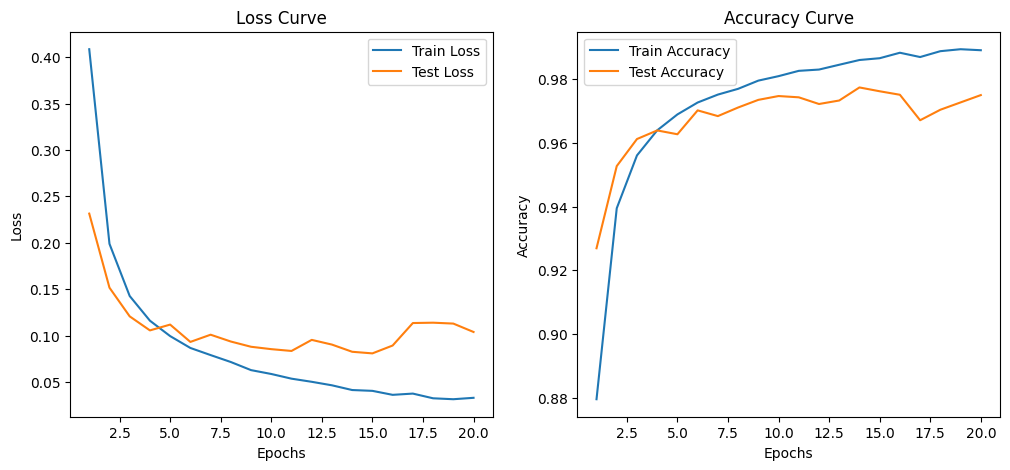

In [18]:
# Train model
pretrained_model = train_model(model, train_loader, test_loader, epochs=20)

In [19]:
# Save model
torch.save(pretrained_model.state_dict(), 'pretrained_model.pth')
print("Pre-trained model saved as 'pretrained_model.pth'")

Pre-trained model saved as 'pretrained_model.pth'


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.95      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.95      0.99      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.97      0.98     10000



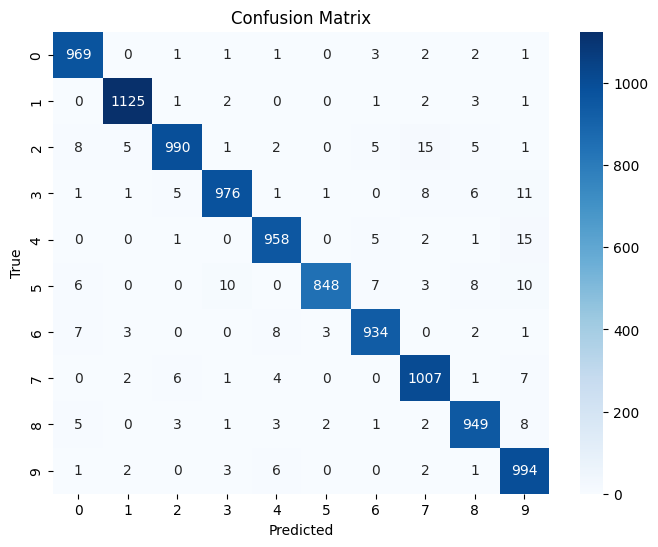

In [20]:
# Evaluate model
evaluate_model(pretrained_model, test_loader, class_names=[str(i) for i in range(10)])

# Fine tuning

In [21]:
from torch.utils.data import DataLoader, Dataset

In [22]:
class FineTunableNN(nn.Module):
    """Neural network model with flexibility for fine-tuning."""
    def __init__(self, num_classes=10, freeze_base=False):
        """
        Args:
            num_classes (int): Number of output classes. Defaults to 10.
            freeze_base (bool): Whether to freeze the base layers for fine-tuning.
        """
        super(FineTunableNN, self).__init__()

        # Base layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()

        # Output layer (can be fine-tuned or replaced)
        self.fc3 = nn.Linear(64, num_classes)

        # Freeze base layers if specified
        if freeze_base:
            self._freeze_layers()

    def _freeze_layers(self):
        """Freeze parameters of the base layers."""
        for layer in [self.fc1, self.relu1, self.fc2, self.relu2]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, x):
        """Forward pass."""
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


In [23]:
# Data Loading and Preprocessing
def load_extracted_samples(selected_classes):
    """Load extracted samples for selected classes."""
    extracted_data = []
    extracted_labels = []

    for cls in selected_classes:
        samples_path = f'extracted_samples/class_{cls}.pt'
        if os.path.exists(samples_path):
            samples = torch.load(samples_path)
            for data, label in samples:
                extracted_data.append(data)
                extracted_labels.append(label)
        else:
            print(f"No samples found for class {cls} at {samples_path}.")

    extracted_dataset = CustomDataset(extracted_data, extracted_labels)
    return extracted_dataset


In [24]:
class CustomDataset(Dataset):
    """Custom dataset to handle extracted data."""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [25]:
# Fine-tune the pre-trained model
def fine_tune_model(pretrained_model_path, finetune_loader, test_loader, epochs, lr):
    """Fine-tune the pre-trained model using new samples."""
    model = SimpleNN()
    model.load_state_dict(torch.load(pretrained_model_path))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in finetune_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(finetune_loader)
        train_accuracy = correct / len(finetune_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        model.eval()
        test_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_accuracy = correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Plot training/testing accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Fine-tune Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Fine-tune Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Fine-tune Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Fine-tune Train Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Fine-tune Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Fine-tune Accuracy over Epochs')
    plt.legend()
    plt.show()

    return model


In [26]:
def evaluate_finetuned_model(model, data_loader, class_names):
    """Evaluate fine-tuned model and display metrics."""
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Ensure class names match the number of unique labels
    unique_labels = sorted(set(all_labels))

    # Fix: Create a mapping between original labels and class names
    label_to_classname = {label: str(label) for label in unique_labels}
    adjusted_class_names = [label_to_classname[label] for label in unique_labels]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=adjusted_class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=adjusted_class_names, yticklabels=adjusted_class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [27]:
# Define selected classes for fine-tuning
selected_classes = [3, 5, 6]  # Replace with the classes you extracted earlier

In [28]:
# Load extracted samples
finetune_dataset = load_extracted_samples(selected_classes)
finetune_loader = DataLoader(finetune_dataset, batch_size=64, shuffle=True)

<ipython-input-23-0c0ae1a23050>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  samples = torch.load(samples_path)


In [29]:
def adjust_state_dict(state_dict):
    adjusted_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("fc1", "fc.1").replace("fc2", "fc.3").replace("fc3", "fc.5")
        adjusted_dict[new_key] = value
    return adjusted_dict

In [30]:
import io

# Load the pretrained model safely
pretrained_model_path = 'pretrained_model.pth'
try:
    with open(pretrained_model_path, 'rb') as f:
        buffer = io.BytesIO(f.read())  # Load the model file into a buffer
        model = SimpleNN()
        state_dict = torch.load(buffer, weights_only=True)  # Use weights_only=True for security
        model.load_state_dict(state_dict)
except FileNotFoundError:
    print(f"Error: The file {pretrained_model_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


<ipython-input-25-874195b1a058>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path))


Epoch 1/20 -> Train Loss: 0.1723, Train Acc: 0.9617, Test Loss: 0.0993, Test Acc: 0.9753
Epoch 2/20 -> Train Loss: 0.1527, Train Acc: 0.9670, Test Loss: 0.0958, Test Acc: 0.9763
Epoch 3/20 -> Train Loss: 0.1372, Train Acc: 0.9700, Test Loss: 0.0934, Test Acc: 0.9765
Epoch 4/20 -> Train Loss: 0.1241, Train Acc: 0.9730, Test Loss: 0.0921, Test Acc: 0.9760
Epoch 5/20 -> Train Loss: 0.1128, Train Acc: 0.9743, Test Loss: 0.0912, Test Acc: 0.9758
Epoch 6/20 -> Train Loss: 0.1046, Train Acc: 0.9767, Test Loss: 0.0911, Test Acc: 0.9754
Epoch 7/20 -> Train Loss: 0.0959, Train Acc: 0.9783, Test Loss: 0.0914, Test Acc: 0.9751
Epoch 8/20 -> Train Loss: 0.0889, Train Acc: 0.9797, Test Loss: 0.0922, Test Acc: 0.9754
Epoch 9/20 -> Train Loss: 0.0832, Train Acc: 0.9817, Test Loss: 0.0933, Test Acc: 0.9747
Epoch 10/20 -> Train Loss: 0.0780, Train Acc: 0.9817, Test Loss: 0.0945, Test Acc: 0.9740
Epoch 11/20 -> Train Loss: 0.0739, Train Acc: 0.9830, Test Loss: 0.0963, Test Acc: 0.9738
Epoch 12/20 -> Trai

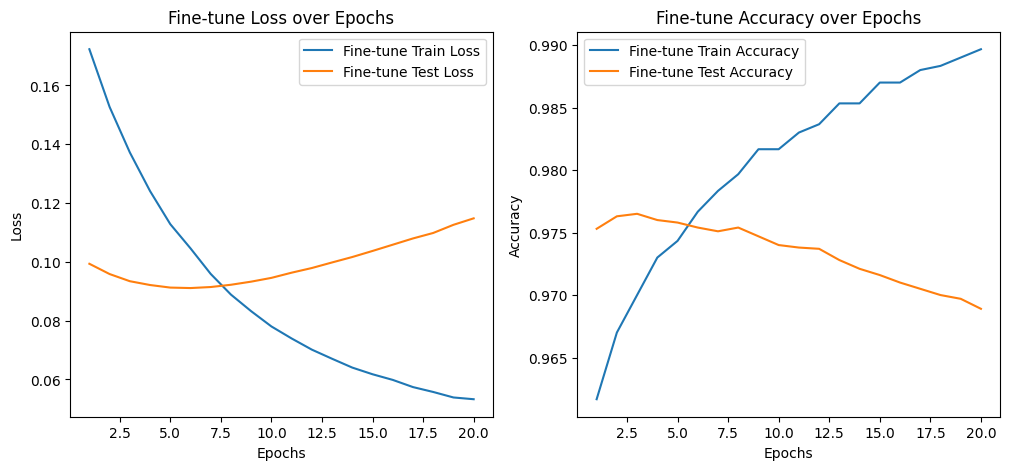

In [31]:
finetuned_model = fine_tune_model(
    pretrained_model_path=pretrained_model_path,
    finetune_loader=finetune_loader,
    test_loader=test_loader,
    epochs=20,  # Adjust the number of epochs as needed
    lr=0.00001  # Adjust the learning rate for fine-tuning
)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.93      0.95      1032
           3       0.89      0.99      0.94      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.99      0.95      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



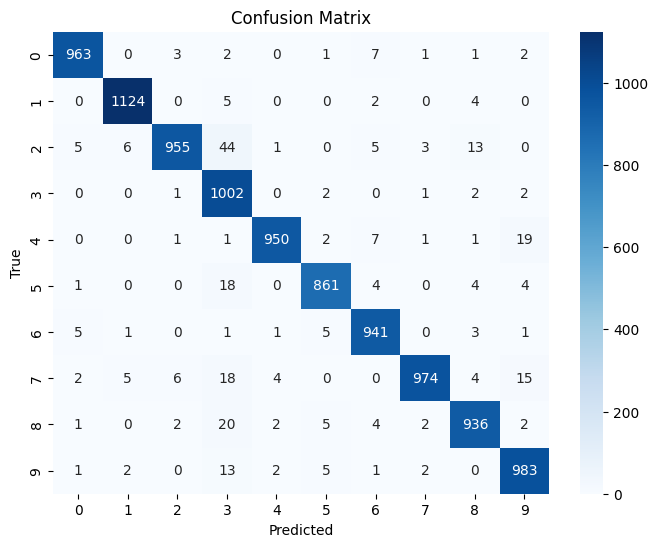

In [32]:
# Evaluate the fine-tuned model
class_names = [str(cls) for cls in selected_classes]
evaluate_finetuned_model(finetuned_model, test_loader, class_names)

In [33]:
# Save the fine-tuned model
finetuned_model_path = 'finetuned_model.pth'  # Choose a path for your fine-tuned model
torch.save(finetuned_model.state_dict(), finetuned_model_path)
print(f"Fine-tuned model saved as '{finetuned_model_path}'")

Fine-tuned model saved as 'finetuned_model.pth'


In [34]:
# Function to compute task vector
def compute_task_vector(pretrained_model_path, finetuned_model_path):
    """Computes the task vector by subtracting pre-trained weights from fine-tuned weights."""
    # Load pre-trained model weights
    pretrained_state_dict = torch.load(pretrained_model_path)
    # Load fine-tuned model weights
    finetuned_state_dict = torch.load(finetuned_model_path)

    task_vector = {}
    for key in pretrained_state_dict.keys():
        task_vector[key] = finetuned_state_dict[key] - pretrained_state_dict[key]

    return task_vector

In [35]:
# Compute and print the task vector
task_vector = compute_task_vector(pretrained_model_path, finetuned_model_path)
print("Task Vector:")
for key, value in task_vector.items():
    print(f"{key}: {value.shape}")

Task Vector:
fc1.weight: torch.Size([128, 784])
fc1.bias: torch.Size([128])
fc2.weight: torch.Size([64, 128])
fc2.bias: torch.Size([64])
fc3.weight: torch.Size([10, 64])
fc3.bias: torch.Size([10])


<ipython-input-34-620f51f2661d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state_dict = torch.load(pretrained_model_path)
<ipython-input-34-620f51f2661d>:7:

In [36]:
# Save the task vector
task_vector_path = 'task_vector.pth'  # Choose a path to save the task vector
torch.save(task_vector, task_vector_path)
print(f"Task vector saved as '{task_vector_path}'")

Task vector saved as 'task_vector.pth'


# Now train another similar model on Fashion MNIST dataset

In [37]:
# Load FashionMNIST dataset
def load_fashionmnist_data():
    """Load FashionMNIST dataset with normalization."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize dataset
    ])
    train_dataset = datasets.FashionMNIST(root='data_fashion', train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root='data_fashion', train=False, transform=transform, download=True)
    return train_dataset, test_dataset

In [38]:
fashion_train_dataset, fashion_test_dataset = load_fashionmnist_data()

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]


Extracting data_fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to data_fashion/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting data_fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data_fashion/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.10MB/s]


Extracting data_fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data_fashion/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.2MB/s]

Extracting data_fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data_fashion/FashionMNIST/raw



In [39]:
# Create data loaders
fashion_train_loader = DataLoader(fashion_train_dataset, batch_size=64, shuffle=True)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=64, shuffle=False)

In [40]:
# Initialize a new model (or load a pre-trained one if needed)
fashion_model = SimpleNN()

Epoch 1/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:03<00:00, 46.10it/s]


Epoch 1/20 -> Train Loss: 0.5123, Test Loss: 0.4432, Train Acc: 0.8139, Test Acc: 0.8368


Epoch 2/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 61.81it/s]


Epoch 2/20 -> Train Loss: 0.3768, Test Loss: 0.4054, Train Acc: 0.8620, Test Acc: 0.8545


Epoch 3/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 61.42it/s]


Epoch 3/20 -> Train Loss: 0.3380, Test Loss: 0.3820, Train Acc: 0.8745, Test Acc: 0.8608


Epoch 4/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 53.19it/s]


Epoch 4/20 -> Train Loss: 0.3138, Test Loss: 0.3821, Train Acc: 0.8834, Test Acc: 0.8611


Epoch 5/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 62.30it/s]


Epoch 5/20 -> Train Loss: 0.2981, Test Loss: 0.3599, Train Acc: 0.8898, Test Acc: 0.8717


Epoch 6/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 57.58it/s]


Epoch 6/20 -> Train Loss: 0.2829, Test Loss: 0.3417, Train Acc: 0.8955, Test Acc: 0.8784


Epoch 7/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 60.45it/s]


Epoch 7/20 -> Train Loss: 0.2674, Test Loss: 0.3394, Train Acc: 0.9006, Test Acc: 0.8804


Epoch 8/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 61.13it/s]


Epoch 8/20 -> Train Loss: 0.2600, Test Loss: 0.3396, Train Acc: 0.9024, Test Acc: 0.8813


Epoch 9/20 - Validation: 100%|████████████████████████████████████| 157/157 [00:02<00:00, 56.93it/s]


Epoch 9/20 -> Train Loss: 0.2450, Test Loss: 0.3415, Train Acc: 0.9081, Test Acc: 0.8828


Epoch 10/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.71it/s]


Epoch 10/20 -> Train Loss: 0.2381, Test Loss: 0.3464, Train Acc: 0.9104, Test Acc: 0.8786


Epoch 11/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.47it/s]


Epoch 11/20 -> Train Loss: 0.2286, Test Loss: 0.3561, Train Acc: 0.9133, Test Acc: 0.8819


Epoch 12/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:03<00:00, 45.87it/s]


Epoch 12/20 -> Train Loss: 0.2191, Test Loss: 0.3532, Train Acc: 0.9172, Test Acc: 0.8820


Epoch 13/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.43it/s]


Epoch 13/20 -> Train Loss: 0.2100, Test Loss: 0.3359, Train Acc: 0.9204, Test Acc: 0.8864


Epoch 14/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 61.25it/s]


Epoch 14/20 -> Train Loss: 0.2044, Test Loss: 0.3674, Train Acc: 0.9221, Test Acc: 0.8833


Epoch 15/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:03<00:00, 45.21it/s]


Epoch 15/20 -> Train Loss: 0.1958, Test Loss: 0.3556, Train Acc: 0.9260, Test Acc: 0.8857


Epoch 16/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 60.65it/s]


Epoch 16/20 -> Train Loss: 0.1893, Test Loss: 0.3384, Train Acc: 0.9290, Test Acc: 0.8851


Epoch 17/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 62.62it/s]


Epoch 17/20 -> Train Loss: 0.1854, Test Loss: 0.3527, Train Acc: 0.9305, Test Acc: 0.8857


Epoch 18/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 56.46it/s]


Epoch 18/20 -> Train Loss: 0.1771, Test Loss: 0.3617, Train Acc: 0.9333, Test Acc: 0.8869


Epoch 19/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:02<00:00, 62.42it/s]


Epoch 19/20 -> Train Loss: 0.1714, Test Loss: 0.3636, Train Acc: 0.9343, Test Acc: 0.8882


Epoch 20/20 - Validation: 100%|███████████████████████████████████| 157/157 [00:03<00:00, 50.38it/s]


Epoch 20/20 -> Train Loss: 0.1656, Test Loss: 0.3592, Train Acc: 0.9367, Test Acc: 0.8884


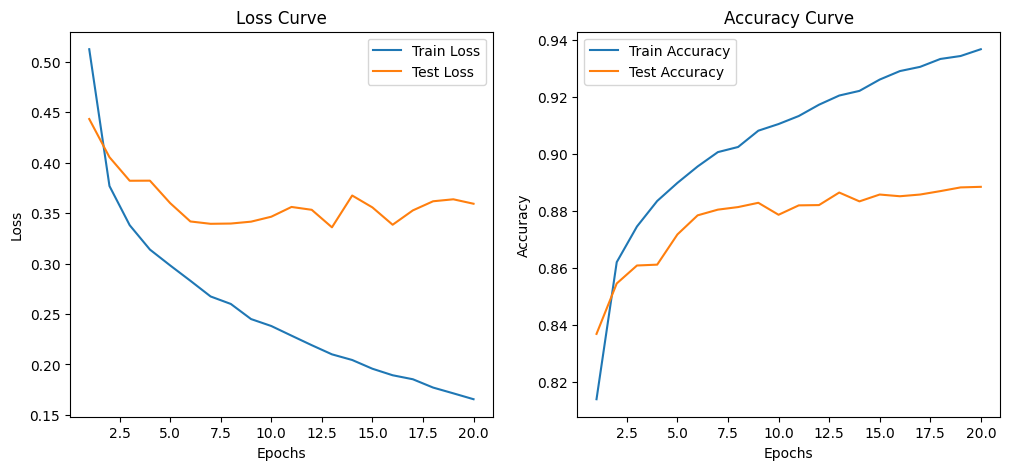

In [41]:
# Train the model on FashionMNIST
trained_fashion_model = train_model(fashion_model, fashion_train_loader, fashion_test_loader, epochs=20)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.81      0.75      0.78      1000
           3       0.87      0.88      0.88      1000
           4       0.75      0.86      0.80      1000
           5       0.95      0.93      0.94      1000
           6       0.70      0.67      0.69      1000
           7       0.90      0.96      0.93      1000
           8       0.97      0.96      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



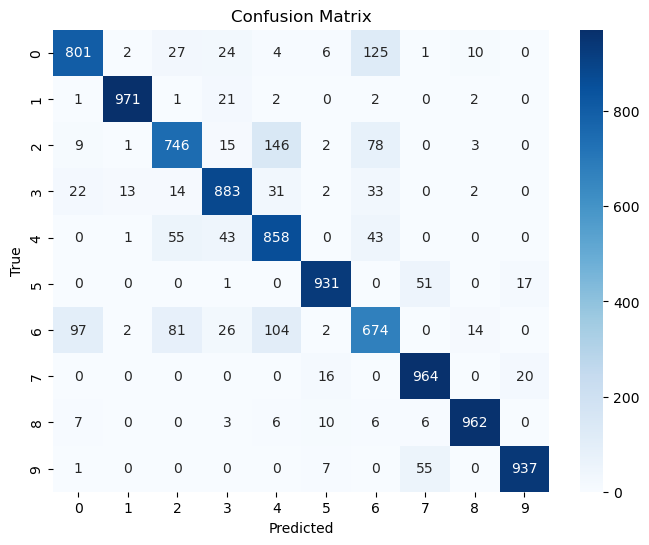

In [ ]:
evaluate_model(trained_fashion_model, fashion_test_loader, class_names=[str(i) for i in range(10)])

 # Adding task vector

In [42]:
# Load the task vector
task_vector_path = 'task_vector.pth'  # Path to the saved task vector
task_vector = torch.load(task_vector_path)

# Add task vector to FashionMNIST model weights
fashion_model_state_dict = fashion_model.state_dict()
for key in task_vector.keys():
    if key in fashion_model_state_dict:
        fashion_model_state_dict[key] += task_vector[key]
fashion_model.load_state_dict(fashion_model_state_dict)

<ipython-input-42-3604c9d02fd7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  task_vector = torch.load(task_vector_path)


<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.77      0.81      1000
           3       0.90      0.90      0.90      1000
           4       0.83      0.83      0.83      1000
           5       0.93      0.97      0.95      1000
           6       0.64      0.80      0.71      1000
           7       0.92      0.94      0.93      1000
           8       0.97      0.96      0.97      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



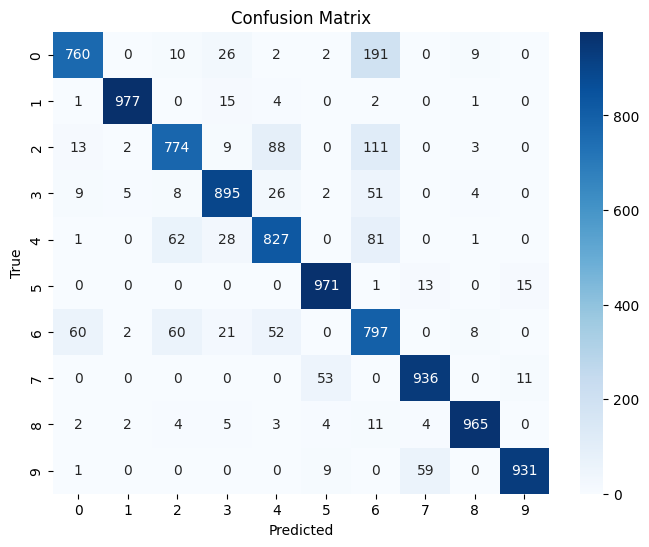

In [43]:
evaluate_model(trained_fashion_model, fashion_test_loader, class_names=[str(i) for i in range(10)])